In [ ]:
!pip install torch
!pip install scipy 
!pip install torchmetrics
!pip install wandb
import os

from PIL import Image
import random
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import pickle
from sklearn import manifold
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
import scipy.io
from google.colab import drive
drive.mount("/content/gdrive",force_remount=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 8.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 KB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 17.0 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=88

In [ ]:
import os
from time import time
from tqdm import tqdm
import numpy

import torch
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from torchvision.transforms import transforms

import glob
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
import wandb
wandb.login(key="1262a78bcdb91721d1f31364cec1d26409dd981e")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, data ,transform=None, target_transform=None):
        self.img_labels = data['y_aug']
        self.img_dir = data['X_aug']
        self.transform = transform
        self.data = data

        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = self.img_dir[:,:,:,idx]
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        # print(idx)
        return image, label

In [ ]:
import glob
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
from torchvision.io import read_image



data = scipy.io.loadmat("/content/gdrive/MyDrive/cv1.mat")
data_size = len(data['y'])
# data_size = 2000
data['y'][ data['y'] == 10 ] = 0


transform = transforms.Compose(
    
    [   
        transforms.ToTensor(),
        # transforms.Resize((32,32)),
    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

     ])

aug_transform = transforms.Compose(
    
    [   
        transforms.ToTensor(),
        transforms.RandomGrayscale(p=0.6),
        transforms.RandomRotation(degrees = (0,90)),
        transforms.ColorJitter(brightness=(0.5,1.5), contrast=(1), saturation=(0.5,1.5), hue=(-0.1,0.1)),
        transforms.RandomHorizontalFlip(),
        # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        # transforms.Resize((224, 224)),
    
     ])

train_size = int(data_size*0.70)
test_size = int(data_size*0.20)
val_size = int(data_size*0.10)


# dataset_size = 2000
indices = list(range(data_size))
np.random.shuffle(indices)

test_index = indices[:test_size]
train_index = indices[test_size:test_size+train_size]
val_index = indices[-val_size:]

# increase the size
data['X_aug'] = np.concatenate((data['X'], data['X'][:train_size]),axis=3)
data['y_aug'] = np.concatenate((data['y'], data['y'][:train_size]),axis=0)

# modify the new data
start = data_size
for i in range(len(train_index)):
    transformed_img = aug_transform(data['X'][:,:,:,train_index[i]]).permute(1,2,0).numpy()
    # transformed_img = (data['X'][:,:,:,train_index[i]])
    # print(type(transformed_img))
    # plt.imshow(transformed_img)
    # print(transformed_img.shape)
    # img1 = transformed_img
    data['X_aug'][:,:,:,start] = transformed_img
    data['y_aug'][start] = data['y'][train_index[i]]
                                     
    start+=1

train_index = np.concatenate((indices[test_size:test_size+train_size],np.arange(data_size,int(data_size+train_size*0.3),1)),axis = 0).astype(int)

dataset = CustomImageDataset(data,transform)

g = torch.Generator()
g.manual_seed(42)
batch_size = 64

train_sampler=SubsetRandomSampler(train_index, generator=g)
val_sampler=SubsetRandomSampler(val_index, generator=g)
test_sampler=SubsetRandomSampler(test_index, generator=g)

trainloader = torch.utils.data.DataLoader(dataset, sampler = train_sampler, batch_size=batch_size,num_workers=2)
valloader = torch.utils.data.DataLoader(dataset, sampler = val_sampler, batch_size=batch_size,num_workers=2)
testloader = torch.utils.data.DataLoader(dataset, sampler = test_sampler, batch_size=batch_size,num_workers=2)

In [ ]:
print(len(train_index))

66662


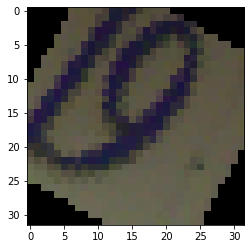

In [ ]:
img = aug_transform(data['X'][:,:,:,1]).permute(1,2,0).numpy()
plt.imshow(img)

In [ ]:
# transform = transforms.Compose(
    
#     [   
#         transforms.ToTensor(),
#         # transforms.Resize((32,32)),
#     #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

#      ])

In [ ]:
# data['X_aug'] = np.concatenate((data['X'], data['X'][:train_size]),axis=3)
# data['y_aug'] = np.concatenate((data['y'], data['y'][:train_size]),axis=0)

In [ ]:
# train_index[9]

73266

<class 'numpy.ndarray'>
(32, 32, 3)
<class 'numpy.ndarray'>
(32, 32, 3)


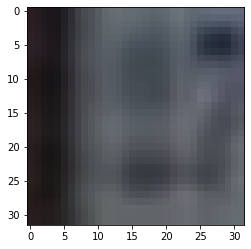

In [ ]:
# data['X_aug1'] = np.concatenate((data['X'], data['X'][:train_size]),axis=3)
# data['y_aug1'] = np.concatenate((data['y'], data['y'][:train_size]),axis=0)

# start = data_size
# for i in range(len(train_index[:2])):
#     transformed_img = (data['X'][:,:,:,train_index[i]])
#     print(type(transformed_img))
#     plt.imshow(transformed_img)
#     print(np.array(transformed_img).shape)
#     # img1 = transformed_img
#     data['X_aug1'][:,:,:,start] = transformed_img
#     data['y_aug1'][start] = data['y'][train_index[i]]
                                     
#     start+=1

[1]
<class 'numpy.ndarray'>


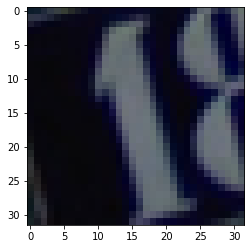

In [ ]:
# plt.imshow(data['X_aug1'][:,:,:,data_size])
# print(data['y_aug'][data_size])
# print(type(data['X_aug1'][:,:,:,data_size]))

In [ ]:
# aug_images = []
# for i in range(len(train_index[:10])):
#       transformed_img = transform(data['X'][:,:,:,train_index[i]])
#       # data['y']=np.concatenate( (data['y'] ,np.array([ data['y'][train_index[i]] ])) ,axis=0)
#       # data['X']=np.concatenate((data['X'] ,np.array([transformed_img])),axis=3)
#       aug_images.append(transformed_img)

In [ ]:
# len(data['X'][[0, 8, 6, 7, 3, 2, 5, 1, 9, 4]])

10

In [ ]:
class Model(nn.Module):
    def __init__(self,mode="default",drops="none"):
      
        super().__init__()

        #conv2d main args = in_channel, out_channel, kernel size, stride, padding
        #MaxPool2d main args = kernel size, stride

        self.conv1 = nn.Conv2d(3, 32 , kernel_size=(3,3) ,padding=1)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1)
        self.relu2= nn.ReLU()
        
        #Classification head 
        self.fc = nn.Linear(int(262144/4), 10)
     

        # if mode=="Zero":
        #   torch.nn.init.zeros_(self.conv1.weight)
        #   torch.nn.init.zeros_(self.conv2.weight)
        #   torch.nn.init.zeros_(self.fc.weight)


        # elif mode=="Random":
        #   torch.nn.init.normal_(self.conv1.weight)
        #   torch.nn.init.normal_(self.conv2.weight)
        #   torch.nn.init.normal_(self.fc.weight)

        # elif mode=="He":
        #   torch.nn.init.kaiming_uniform_(self.conv1.weight)
        #   torch.nn.init.kaiming_uniform_(self.conv2.weight)
        #   torch.nn.init.kaiming_uniform_(self.fc.weight)
        
    def forward(self, x):
        x = self.conv1(x)
        x=self.relu1(x)

        x=self.conv2(x)
        x=self.relu2(x)
        
        x = torch.flatten(x, start_dim=1)
        
        # Classification head
        x = self.fc(x)      

        # if self.drops=="after_conv":
        #   x = self.drop(x)
        # x = torch.flatten(x, 1) 
        # x = self.fc1(x)

        # if self.drops=="after_fc":
        #   x = self.drop(x)
        
        return x
      
    # def get_features(self, x):
    #     x = self.conv1(x)
    #     x=self.relu1(x)
    #     x = self.conv2(x)
    #     x=self.relu2(x)
        
    #     x = torch.flatten(x, 1) 
    #     return x
      
    # def get_outs(self, x):

    #     x = self.relu1(self.conv1(x))
    #     y = self.relu2(self.conv2(x))
     
    #     return x,y

    
# def my_loss(outputs,labels):
#   loss = torch.mean(-labels*torch.log(outputs)-(1-labels)*torch.log((1-outputs)))
#   return loss

In [ ]:
model = Model()
optimizer = Adam(model.parameters(), lr=0.001)
criterion =  nn.CrossEntropyLoss()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project="Q1",
)
## command to log gradients to wandb
wandb.watch(model)  ## pass name of model for which we want to log gradients, helps for analysis


total_loss_train = []
total_loss_validation = []


## command to log gradients to wandb
# wandb.watch(model)  ## pass name of model for which we want to log gradients, helps for analysis
epochs = 10
for epoch in range(epochs):  
    # print(epoch + 1)
    
    batch_loss_train=0
    batch_loss_val=0

    num_batches = 0
    correct = 0
    total = 0
    cnt=0
    for i, data in enumerate(trainloader, 0):
        


        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.reshape((len(labels),))
       
        total += labels.size(0)
        cnt+=1

        train_pred = torch.max(outputs, 1).indices
        correct += int(torch.sum(train_pred == labels))
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_loss_train+=loss.item()
        running_loss = loss.item()
        # print('[epoch, batch] =  [%d, %5d] loss: %.6f' %(epoch + 1, i, running_loss))
        num_batches+=1
        # print(num_batches)

    batch_loss_train/=num_batches
    acc = 100 * correct / total

    wandb.log(
          {"train accuracy" : acc,"train loss":batch_loss_train}
          )

    print("Trainging Accuracy ",acc)
    print("Trianing Loss ",batch_loss_train)

    total_loss_train.append(batch_loss_train)
    
    # Valdiation Loop
    with torch.no_grad():
      correct = 0
      total = 0
      cnt=0
      # ✨ W&B: parameters
      log_counter = 0
      NUM_BATCHES_TO_LOG = 10
      NUM_IMAGES_PER_BATCH = 64
      i=-1
      for data in valloader:
          i+=1
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          # Get Prediction
          outputs = model(inputs)

          # Compute loss 
          total += labels.size(0)
          cnt+=1
          #labels = labels.float()
          labels = labels.reshape((len(labels),))
          
          #print(outputs.shape)
          loss_val = criterion(outputs, labels)
          batch_loss_val += loss_val.item()
          

          out_cpu = outputs.cpu()
          predicted = [np.argmax(x) for x in out_cpu]
          predicted = torch.Tensor(predicted).to(device)
          correct += (predicted == labels).sum().item()

  
      acc = 100 * correct / total
      total_loss_validation += [batch_loss_val/cnt]
      # ✨ W&B: Log accuracy across training epochs, to visualize in the UI
     

      print("Validation loss is ",batch_loss_val/cnt)
      print("Validation Acc is ", acc)

      wandb.log(
          {"val accuracy" :acc ,"val loss":batch_loss_val/cnt}
          )

print('Finished Training')

wandb: Currently logged in as: ishit20380 (drake). Use `wandb login --relogin` to force relogin


Trainging Accuracy  74.30620143410039
Trianing Loss  0.8570001710227722
Validation loss is  0.6584860882033472
Validation Acc is  79.75426621160409
Trainging Accuracy  83.04731331193183
Trianing Loss  0.5885266236059954
Validation loss is  0.5822001120318537
Validation Acc is  82.60750853242321
Trainging Accuracy  85.06045423179623
Trianing Loss  0.5191140502777072
Validation loss is  0.5350397979435714
Validation Acc is  84.12286689419795
Trainging Accuracy  86.27103897272809
Trianing Loss  0.4786605619308816
Validation loss is  0.5246119696161021
Validation Acc is  84.42320819112628
Trainging Accuracy  87.06909483663857
Trianing Loss  0.44565832606318356
Validation loss is  0.5106082136216371
Validation Acc is  84.90102389078498
Trainging Accuracy  87.89265248567399
Trianing Loss  0.41581990772182564
Validation loss is  0.49673931793026305
Validation Acc is  85.28327645051195
Trainging Accuracy  88.46269238846719
Trianing Loss  0.39461493214696014
Validation loss is  0.52087850000547

In [ ]:
true = torch.tensor([]).to(device)
pred = torch.tensor([]).to(device)
      

from torchmetrics.classification import F1Score
# print(f1_true)
# print(f1_pred)


true_val = torch.tensor([]).to(device)
pred_val = torch.tensor([]).to(device)
ll = 0


missclassified_images = []
missclassified_images_label = []
missclassified_images_pred = []

total_loss_validation = []

with torch.no_grad():
      correct = 0
      total = 0
      cnt=0
      # ✨ W&B: parameters
      log_counter = 0
      NUM_BATCHES_TO_LOG = 10
      NUM_IMAGES_PER_BATCH = 64
      i=-1
      batch_loss_val= 0
      for data in testloader:
          
          i+=1
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          # Get Prediction
          outputs = model(inputs)

          # Compute loss 
          total += labels.size(0)
          cnt+=1
          #labels = labels.float()
          labels = labels.reshape((len(labels),))
          
          #print(outputs.shape)
          loss_val = criterion(outputs, labels)
          batch_loss_val += loss_val.item()
          

          out_cpu = outputs.cpu()
          predicted = [np.argmax(x) for x in out_cpu]
          predicted = torch.Tensor(predicted).to(device)
          correct += (predicted == labels).sum().item()

          for r in range(len(predicted)):
            if(predicted[r] != labels[r]):
              missclassified_images.append(inputs[r])
              missclassified_images_label.append(labels[r])
              missclassified_images_pred.append(predicted[r])
          true_val = torch.cat((true_val, labels))
          pred_val = torch.cat((pred_val, predicted))

          

          ll+=len(labels)
  
      acc = 100 * correct / total
      total_loss_validation += [batch_loss_val/cnt]

      
      # ✨ W&B: Log accuracy across training epochs, to visualize in the UI
     


f1 = F1Score(task="multiclass", num_classes=10)
print(f1(pred_val.cpu(), true_val.cpu()))
# print(test_accuracy_epoch*100)
print(acc)      
print('Finished Testing...')



tensor(0.8504)
85.0385639205515
Finished Testing...


In [ ]:
all_labels = [0,1,2,3,4,5,6,7,8,9]
# preds = pred_val.cpu().numpy().astype(int)
# y_true = true_val.cpu().numpy().astype(int)
preds = []
y_true = []
for i in pred_val.cpu():
    preds.append((int(i.item())))
for i in true_val.cpu():
    y_true.append((int(i.item())))

wandb.log({"my_conf_mat_id" : wandb.plot.confusion_matrix( 
            preds=preds, y_true=y_true,
            class_names=all_labels)})

In [ ]:
filename = '/content/gdrive/MyDrive/Datasets/cnn.sav'
pickle.dump(model, open(filename, 'wb'))